In [1]:
from importlib import import_module
import tensorflow as tf
import keras
from keras.api._v2 import keras as KerasAPI
keras: KerasAPI = import_module("tensorflow.keras")
print(tf.__version__)

from keras import Model, layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils import plot_model

from keras.utils import load_img
from keras.utils import img_to_array

import os

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

2.10.0


In [2]:
path = ''
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/deepLearningAs3/'

pathfinal = path + 'model_history_II/'

epoch_val = 3000
batch_size_val = 32
threshold_val = 1e-4
inputShape = 784

random_state_global = 42
learning_rate_val = 1e-3

Hidden_layer_I_N = 20
Hidden_layer_II_N = 15
Hidden_layer_III_N = 10
Output_layer_N = 5

Hidden_layer_ED_N = 400

Hidden_layer_Activation = "tanh"
Output_layer_Activation = "softmax"

Output_layer_Encoder_Activation = "linear"


epsilon_val = 1e-8
beta_1_val = 0.9
beta_2_val = 0.999


class_l_r_to_d = {0:0, 1:1, 2:2, 4:3, 9:4}
class_l_d_to_r = {0:0, 1:1, 2:2, 3:4, 4:9}

In [3]:
import os
import shutil

folder_name = pathfinal

# Get all files in the folder
files = os.listdir(folder_name)

# Loop through the files and delete them
for file in files:
    file_path = os.path.join(folder_name, file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        if os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f"Error deleting {file_path}: {e}")

read and saving data

In [4]:
%%script echo skipping
# level 0 path
l0 = 'Group_20'

DATASET = {0:pd.DataFrame(), 1:pd.DataFrame(), 2:pd.DataFrame()}
temp_dict = {'train':0, 'val':1, 'test':2}

# iterate over files in
# that l0
for l1 in os.listdir(l0):
    f1 = os.path.join(l0, l1)
    for l2 in os.listdir(f1):
        f2 = os.path.join(f1, l2)
        for l3 in os.listdir(f2):
            f3 = os.path.join(f2, l3)
            # print(f3)
            img = load_img(f3, color_mode = "grayscale")
            data_point = tf.squeeze(tf.constant(img_to_array(img)))
            # print("shape:", data_point.shape) # shape: (28, 28)
            # data_point = data_point/255
            # print(tf.math.reduce_min(data_point), tf.math.reduce_max(data_point))
            # plt.imshow(data_point)
            # plt.show()

            temp = tf.reshape(data_point, shape=[-1]).numpy().tolist()
            
            #appending label
            temp.append(int(l2))

            # print("shape:",temp.shape) #shape: (784,)
            row = pd.Series(temp)
            # print('1')
            DATASET[temp_dict[l1]] = pd.concat([DATASET[temp_dict[l1]], row], axis=1)
            # plt.imshow(tf.reshape(temp, shape=(28,28)))
            # plt.show()


df_train = DATASET[0].transpose()
df_valid = DATASET[1].transpose()
df_test = DATASET[2].transpose()

## saving data
df_train.to_csv('df_train.csv', index=False)
df_valid.to_csv('df_valid.csv', index=False)
df_test.to_csv('df_test.csv', index=False)

skipping


In [5]:
def label_encoding(df):
    df[df.columns[-1]] = LabelEncoder().fit_transform(df.iloc[:,-1])
    return df

def normalizing_data(df):
    temp = df[df.columns[-1]]
    df = df/255
    df[df.columns[-1]] = temp
    return df

# plt.figure(figsize=(7, 10))
def data_visualize(df):
  np.random.seed(random_state_global)
  plt.figure(figsize=(12, 12))
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    rand_index = np.random.choice(range(len(df)))
    plt.imshow(tf.reshape(df.iloc[rand_index,:-1], shape=(28,28)), cmap=plt.cm.binary)
    plt.title(f'{class_l_d_to_r[df.iloc[rand_index,-1]]}')
    # plt.axis(False)
  plt.tight_layout()

In [6]:
df_train = pd.read_csv(path+'df_train.csv', dtype='float32')
df_valid = pd.read_csv(path+'df_valid.csv', dtype='float32')
df_test = pd.read_csv(path+'df_test.csv', dtype='float32')

print('df_train:', df_train.groupby(['784']).count().iloc[:,-1].to_dict())
print('df_valid:', df_valid.groupby(['784']).count().iloc[:,-1].to_dict())
print('df_test:', df_test.groupby(['784']).count().iloc[:,-1].to_dict())
print()

print(f'Initial Data Range: {min(df_train.iloc[:,:-1].min())} to {max(df_train.iloc[:,:-1].max())}')

df_train = label_encoding(normalizing_data(df_train))
df_valid = label_encoding(normalizing_data(df_valid))
df_test = label_encoding(normalizing_data(df_test))
print(f'Final Data Range: {min(df_train.iloc[:,:-1].min())} to {max(df_train.iloc[:,:-1].max())}')
print('Label Encoded')

print('Train Data',df_train.shape)
print('Valid Data',df_valid.shape)
print('Test Data' ,df_test.shape)

df_train: {0.0: 2277, 1.0: 2277, 2.0: 2277, 4.0: 2277, 9.0: 2277}
df_valid: {0.0: 759, 1.0: 759, 2.0: 759, 4.0: 759, 9.0: 759}
df_test: {0.0: 759, 1.0: 759, 2.0: 759, 4.0: 759, 9.0: 759}

Initial Data Range: 0.0 to 255.0
Final Data Range: 0.0 to 1.0
Label Encoded
Train Data (11385, 785)
Valid Data (3795, 785)
Test Data (3795, 785)


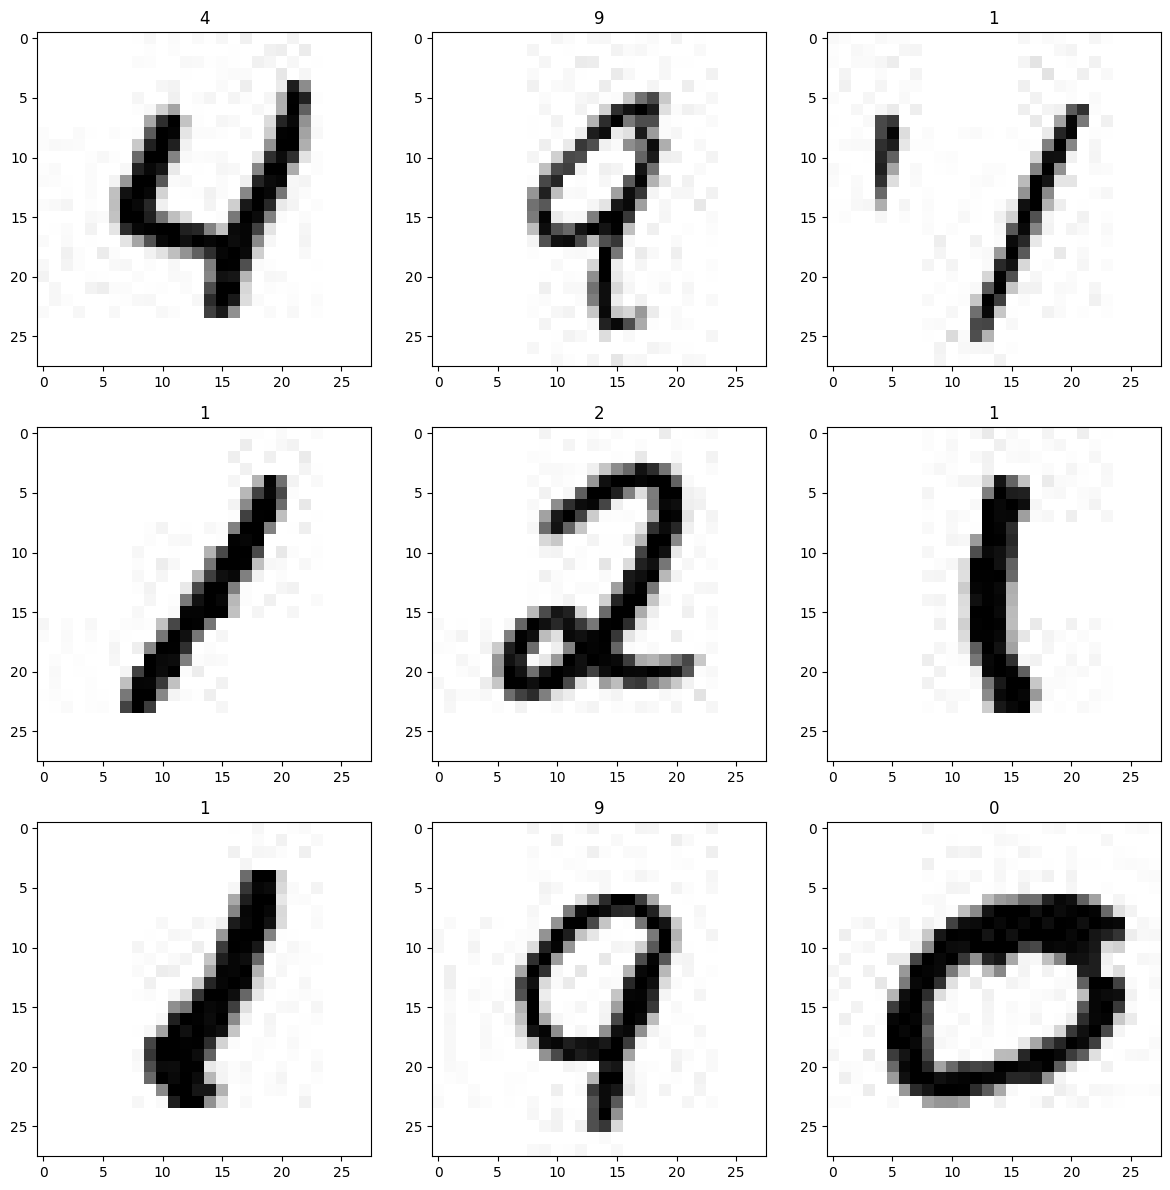

In [7]:
data_visualize(df_train)

In [8]:
# class StopOnThreshold(keras.callbacks.Callback):
#     def __init__(self, threshold):
#         super(StopOnThreshold, self).__init__()
#         self.threshold = threshold
#         self.previous_error = float('inf')
    
#     def on_epoch_end(self, epoch, logs=None):
#         current_error = logs.get('loss')
#         # print(f'\nEpoch {epoch+1} curent Err:{current_error}, Previous Err:{self.previous_error}')
#         if abs(current_error - self.previous_error) < self.threshold:
#             self.model.stop_training = True
#             print('\n\n********\nThreshold Reached\n********\n')
#         self.previous_error = current_error

class ModelSaving(keras.callbacks.Callback):
    def __init__(self):
        self.currentEpoch = 0
        
    def on_epoch_end(self, epoch, logs=None):
        self.currentEpoch = epoch

    def on_train_end(self, logs=None):
        self.model.save(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.tf')
        # print("Training has ended!, model saved")

    
class HistorySaver(keras.callbacks.Callback):
    def __init__(self, initial_history):
        super(HistorySaver, self).__init__()
        self.history = {}
        self.currentEpoch = 0
        
        for key, value in [('loss', initial_history[0]), ('accuracy', initial_history[1]), ('val_loss', initial_history[2]), ('val_accuracy', initial_history[3])]:
            self.history.setdefault(key, []).append(value)
        
        # logs.items() = dict_items([('loss', 1.3612865209579468), ('accuracy', 0.46034255623817444), ('val_loss', 1.1157031059265137), ('val_accuracy', 0.6484848856925964)])
    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)
        self.currentEpoch = epoch
        
    def on_train_end(self, logs=None):
        pd.DataFrame(self.history).to_csv(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.csv', index=False)
        # print("Training has ended!, model history saved")


class HistorySaverAE(keras.callbacks.Callback):
    def __init__(self, initial_history):
        super(HistorySaverAE, self).__init__()
        self.history = {}
        self.currentEpoch = 0
        
        for key, value in [('loss', initial_history[0]), ('val_loss', initial_history[1])]:
            self.history.setdefault(key, []).append(value)
        
    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)
        self.currentEpoch = epoch

        
    def on_train_end(self, logs=None):
        pd.DataFrame(self.history).to_csv(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.csv', index=False)
        # print("Training has ended!, model history saved")


# class EndTrainingCallback(tf.keras.callbacks.Callback):
#     def on_train_end(self, logs=None):
#         print("Training has ended!")

# create the callbacks

model_saver = ModelSaving()

# not initialize HistorySaver() here initialize inside function 
# stop_on_threshold = StopOnThreshold(threshold=threshold_val)

# This means if for 5 epochs the accuracy has no progress on 
# the validation set then it would stop and store the previous best value.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss',
                                                  patience=1,
                                                  min_delta=threshold_val,
                                                  mode='min',
                                                  restore_best_weights=True, 
                                                  verbose=0)

# Adam optimizer

In [9]:
# initializer_I = tf.keras.initializers.HeNormal(seed=random_state_global)
# initializer_II = tf.keras.initializers.HeNormal(seed=random_state_global+1)
# initializer_III = tf.keras.initializers.HeNormal(seed=random_state_global+2)
# initializer_IV = tf.keras.initializers.HeNormal(seed=random_state_global+3)

initializer_I = tf.keras.initializers.GlorotUniform(seed=random_state_global)
initializer_II = tf.keras.initializers.GlorotUniform(seed=random_state_global+1)
initializer_III = tf.keras.initializers.GlorotUniform(seed=random_state_global+2)
initializer_IV = tf.keras.initializers.GlorotUniform(seed=random_state_global+3)
# layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)
# values = initializer(shape=(2, 2))


In [10]:
class Autoencoder_1h_layer(Model):
  def __init__(self, latent_dim, m_name='model'):
    super(Autoencoder_1h_layer, self).__init__()
    self.latent_dim = latent_dim   
    self.m_name = m_name

    self.encoder = keras.Sequential([
      layers.Dense(latent_dim, activation=Hidden_layer_Activation, kernel_initializer=initializer_I),
    ])

    self.decoder = keras.Sequential([
      layers.Dense(inputShape, activation=Output_layer_Encoder_Activation, kernel_initializer=initializer_II),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
  # Override the name property
  @property
  def name(self):
      return self.m_name

class Autoencoder_3h_layer(Model):
  def __init__(self, latent_dim, m_name='model'):
    super(Autoencoder_3h_layer, self).__init__()
    self.latent_dim = latent_dim   
    self.m_name = m_name

    self.encoder = keras.Sequential([
      layers.Dense(Hidden_layer_ED_N, activation=Hidden_layer_Activation, kernel_initializer=initializer_I),
      layers.Dense(latent_dim, activation=Hidden_layer_Activation, kernel_initializer=initializer_II),
    ])

    self.decoder = keras.Sequential([
      layers.Dense(Hidden_layer_ED_N, activation=Hidden_layer_Activation, kernel_initializer=initializer_III),
      layers.Dense(inputShape, activation=Output_layer_Encoder_Activation, kernel_initializer=initializer_IV),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
  # Override the name property
  @property
  def name(self):
      return self.m_name

In [11]:
latent_dim_list = [32, 64, 128, 256]
autoencoder_1h_list = []
autoencoder_3h_list = []
for i in range(2*len(latent_dim_list)):
    tf.random.set_seed(random_state_global)

    autoencoder = None
    if(i<len(latent_dim_list)):
        autoencoder = Autoencoder_1h_layer(latent_dim_list[i], m_name=f'1h_layer_{latent_dim_list[i%4]}')    
    else:
        autoencoder = Autoencoder_3h_layer(latent_dim_list[i%4], m_name=f'3h_layer_{latent_dim_list[i%4]}')

    autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())

    # Evaluate the model initial losses
    initial_train_loss = autoencoder.evaluate(df_train.iloc[:,:-1], df_train.iloc[:,:-1], verbose=0)
    initial_valid_loss = autoencoder.evaluate(df_valid.iloc[:,:-1], df_valid.iloc[:,:-1], verbose=0)

    autoencoder.fit(df_train.iloc[:,:-1], df_train.iloc[:,:-1],
                    epochs=epoch_val,
                    batch_size=batch_size_val,
                    validation_data=(df_valid.iloc[:,:-1], df_valid.iloc[:,:-1]),
                    callbacks=[model_saver, HistorySaverAE((initial_train_loss, initial_valid_loss)), early_stopping_cb], 
                    verbose=0)
    if(i<len(latent_dim_list)):
        autoencoder_1h_list.append(autoencoder)
    else:
        autoencoder_3h_list.append(autoencoder)

2023-04-08 04:22:24.930955: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


INFO:tensorflow:Assets written to: model_history_II/1h_layer_32_9.tf/assets
INFO:tensorflow:Assets written to: model_history_II/1h_layer_64_9.tf/assets
INFO:tensorflow:Assets written to: model_history_II/1h_layer_128_9.tf/assets
INFO:tensorflow:Assets written to: model_history_II/1h_layer_256_9.tf/assets
INFO:tensorflow:Assets written to: model_history_II/3h_layer_32_6.tf/assets
INFO:tensorflow:Assets written to: model_history_II/3h_layer_64_6.tf/assets
INFO:tensorflow:Assets written to: model_history_II/3h_layer_128_6.tf/assets
INFO:tensorflow:Assets written to: model_history_II/3h_layer_256_8.tf/assets


### Observe  the  average  reconstruction errors  for  the  training,  validation, and  test  data.  Average reconstruction error is computed after the model is trained.

In [12]:
for i in range(len(latent_dim_list)):    
    train_loss = autoencoder_1h_list[i].evaluate(df_train.iloc[:,:-1], df_train.iloc[:,:-1], verbose=0)
    valid_loss = autoencoder_1h_list[i].evaluate(df_valid.iloc[:,:-1], df_valid.iloc[:,:-1], verbose=0)
    test_loss = autoencoder_1h_list[i].evaluate(df_test.iloc[:,:-1], df_test.iloc[:,:-1], verbose=0)
    print(f'1h_layer_{latent_dim_list[i]}: train_loss: {train_loss}, valid_loss: {valid_loss}, test_loss: {test_loss}')

print()

for i in range(len(latent_dim_list)):    
    train_loss = autoencoder_3h_list[i].evaluate(df_train.iloc[:,:-1], df_train.iloc[:,:-1], verbose=0)
    valid_loss = autoencoder_3h_list[i].evaluate(df_valid.iloc[:,:-1], df_valid.iloc[:,:-1], verbose=0)
    test_loss = autoencoder_3h_list[i].evaluate(df_test.iloc[:,:-1], df_test.iloc[:,:-1], verbose=0)
    print(f'3h_layer_{latent_dim_list[i]}: train_loss: {train_loss}, valid_loss: {valid_loss}, test_loss: {test_loss}')

1h_layer_32: train_loss: 0.014983855187892914, valid_loss: 0.015242359600961208, test_loss: 0.015137598849833012
1h_layer_64: train_loss: 0.008546704426407814, valid_loss: 0.008786415681242943, test_loss: 0.00870860181748867
1h_layer_128: train_loss: 0.004343844018876553, valid_loss: 0.004546614829450846, test_loss: 0.004498578142374754
1h_layer_256: train_loss: 0.0019342644372954965, valid_loss: 0.002089099260047078, test_loss: 0.002064540283754468

3h_layer_32: train_loss: 0.015326897613704205, valid_loss: 0.015573256649076939, test_loss: 0.015465415082871914
3h_layer_64: train_loss: 0.00886180717498064, valid_loss: 0.009074835106730461, test_loss: 0.009012392722070217
3h_layer_128: train_loss: 0.005101451650261879, valid_loss: 0.005327736027538776, test_loss: 0.005276084877550602
3h_layer_256: train_loss: 0.0025484897196292877, valid_loss: 0.0027331227902323008, test_loss: 0.0026956298388540745


### Take  one  image, from each  class,  from the training, validation,  and  test  set.  Give  their reconstructed images for each of the architectures ( along with original images). 

In [13]:
def plotting_data(df, titile):
    fig, axis = plt.subplots(9, 5, figsize=(8, 20))
    axis = axis.reshape(-1)
    i=0
    axis[i+2].set_title(f'({titile}) Original Images 0, 1, 2, 4, 9')
    for _ in range(5):
        example = tf.convert_to_tensor(df.loc[df[f'{df.shape[1]-1}'] == i].iloc[:1,:-1])
        axis[i].imshow(tf.reshape(example, shape=(28,28)), cmap=plt.cm.binary)
        axis[i].axis(False)
        i+=1

    for m in range(4):
        axis[i+2].set_title(f'Reconstructed Images with {latent_dim_list[m]} latent dimensions and 1 Hidden layer')
        for _ in range(5):
            example = tf.convert_to_tensor(df.loc[df[f'{df.shape[1]-1}'] == (i%5)].iloc[:1,:-1])
            encoded_img = autoencoder_1h_list[m].encoder(example)
            decoded_img = autoencoder_1h_list[m].decoder(encoded_img).numpy()
            axis[i].imshow(decoded_img.reshape(28, 28), cmap=plt.cm.binary)
            axis[i].axis(False)
            i+=1

    for m in range(4):
        axis[i+2].set_title(f'Reconstructed Images with {latent_dim_list[m]} latent dimensions and 3 Hidden layer')
        for _ in range(5):
            example = tf.convert_to_tensor(df.loc[df[f'{df.shape[1]-1}'] == (i%5)].iloc[:1,:-1])
            encoded_img = autoencoder_3h_list[m].encoder(example)
            decoded_img = autoencoder_3h_list[m].decoder(encoded_img).numpy()
            axis[i].imshow(decoded_img.reshape(28, 28), cmap=plt.cm.binary)
            axis[i].axis(False)
            i+=1

    plt.tight_layout()
    plt.show()


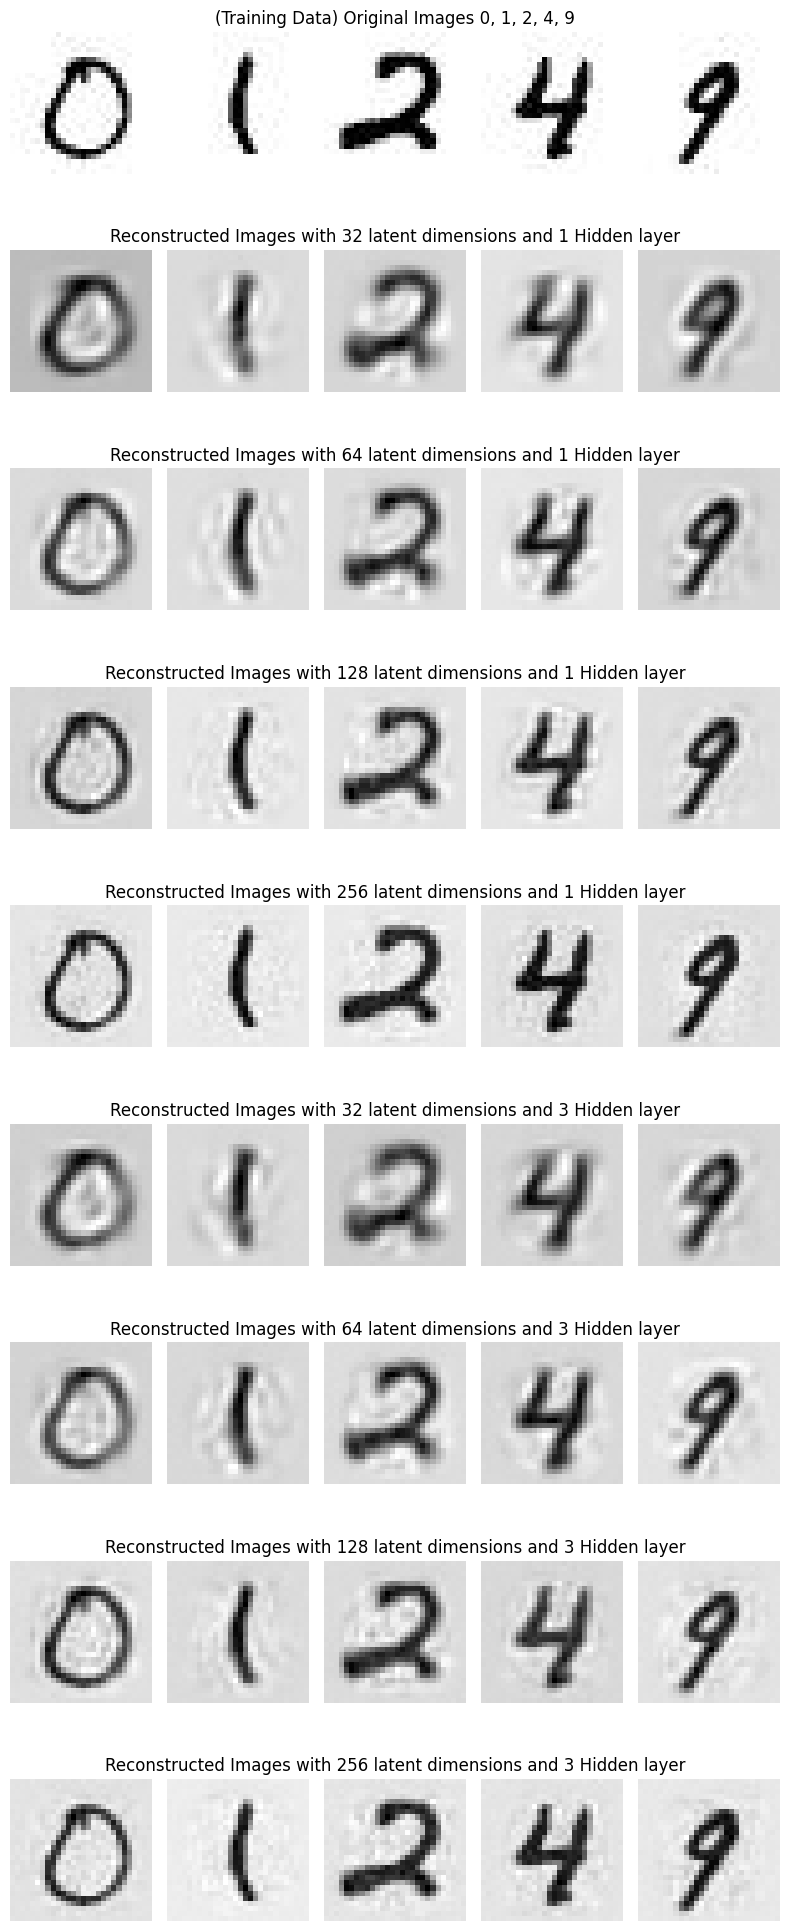

In [14]:
plotting_data(df_train, 'Training Data')

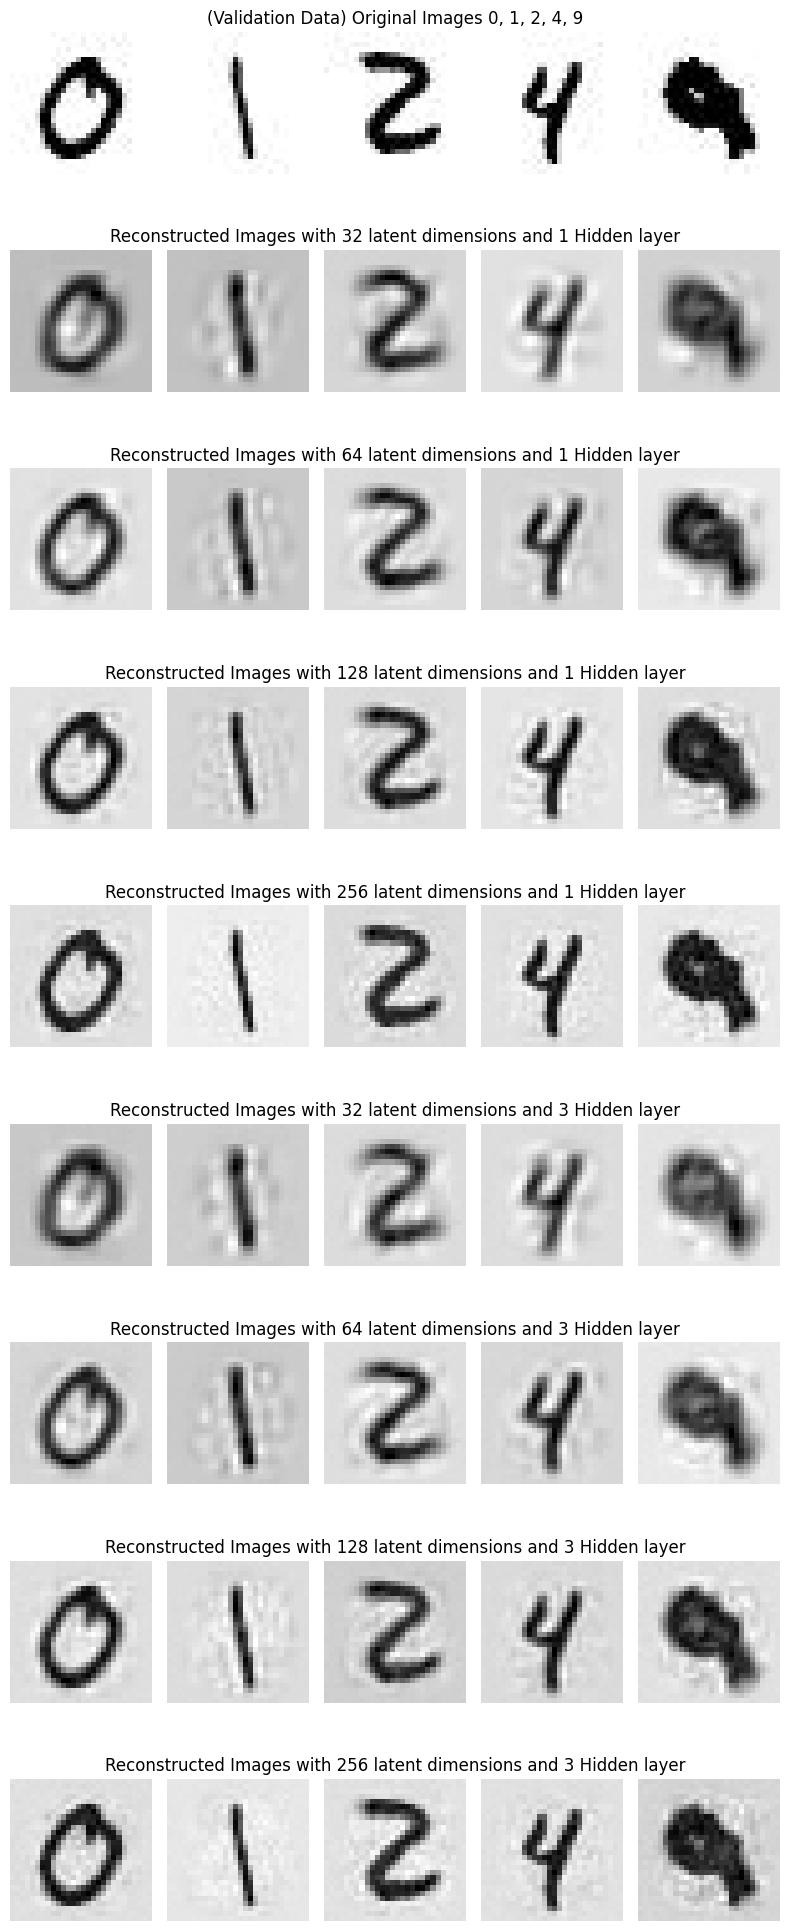

In [15]:
plotting_data(df_valid, 'Validation Data')

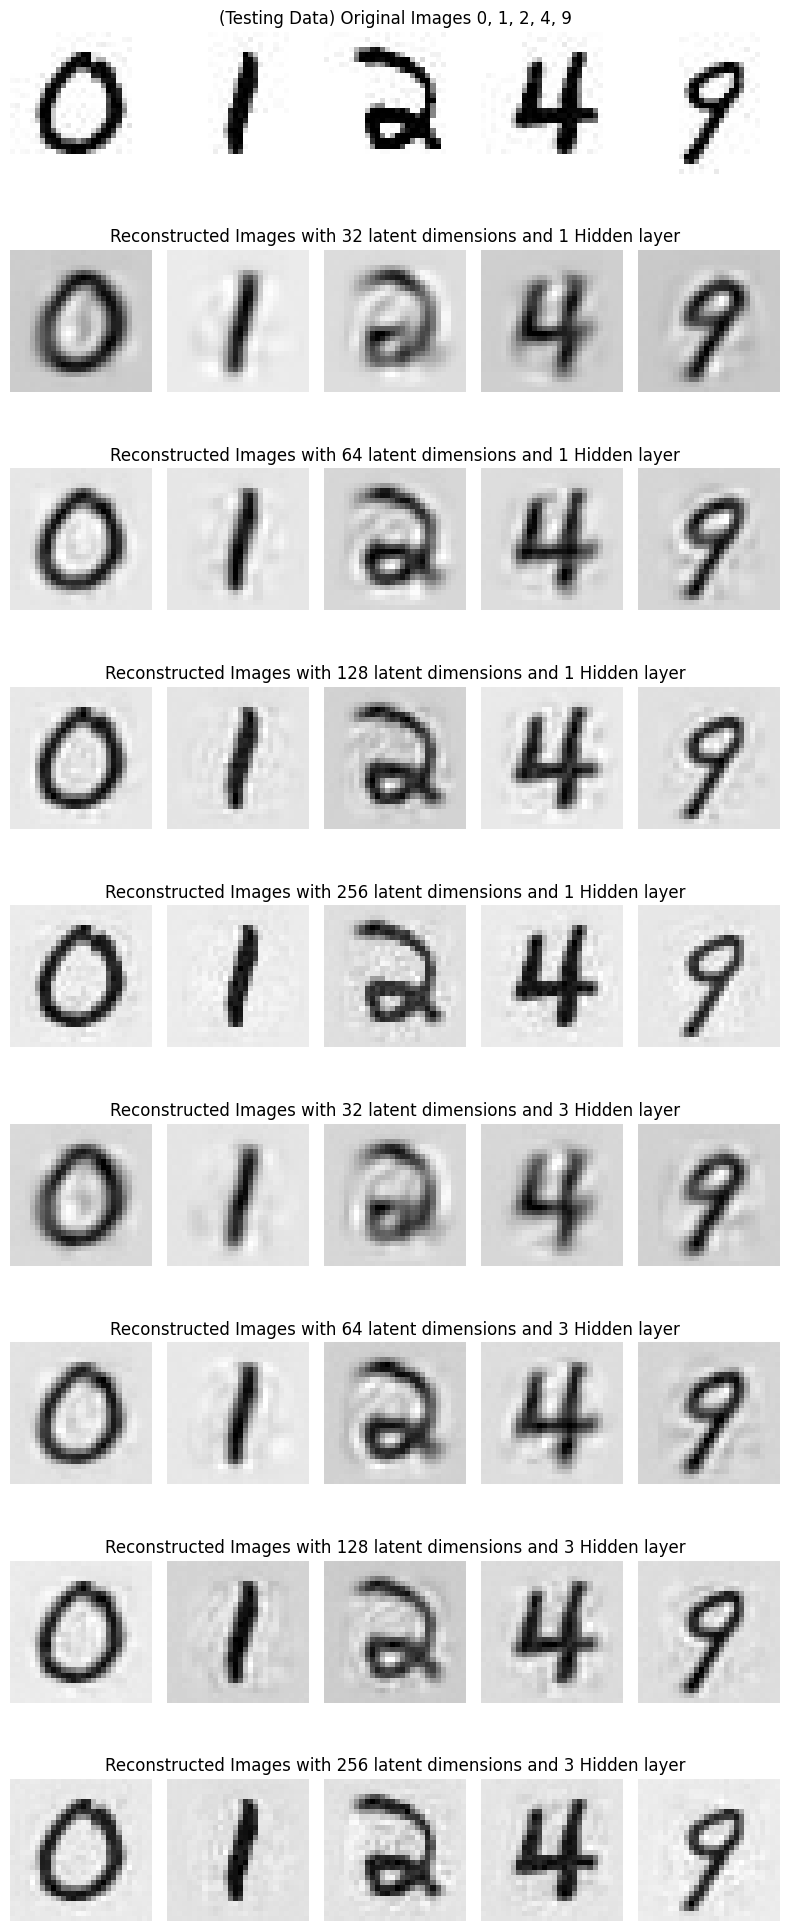

In [16]:
plotting_data(df_test, 'Testing Data')